http://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
## Survival analysis with lifelines
```In the previous section, we introduced how survival analysis is used, needed, and the mathematical objects that it relies on. In this article, we will work with real data and the lifelines library to estimate these mathematical objects.```


In [6]:
%matplotlib inline
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

## Estimating the Survival function using Kaplan-Meier
```For this example, we will be investigating the lifetimes of political leaders around the world. A political leader in this case is defined by a single individual’s time in office who controls the ruling regime. This could be an elected president, unelected dictator, monarch, etc. The birth event is the start of the individual’s tenure, and the death event is the retirement of the individual. Censorship can occur if they are a) still in offices at the time of dataset complilation (2008), or b) die while in office (this includes assassinations).```


In [1]:
import pandas as pd
import lifelines

data = lifelines.datasets.load_dd()

In [2]:
data.sample(6)
#the boolean columns `observed` refers to whether the death (leaving office)
#was observed or not.

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
330,Comoros,581,581.0,Eastern Africa,Africa,Caambi el-Yachourtu,Caambi el-Yachourtu.Comoros.1995.1995.Civilian...,Non-democracy,Civilian Dict,1995,1,1
24,Algeria,615,615.0,Northern Africa,Africa,Liamine Zeroual,Liamine Zeroual.Algeria.1994.1998.Military Dict,Non-democracy,Military Dict,1994,5,1
927,Lebanon,660,660.0,Western Asia,Asia,Fouad Siniora,Fouad Siniora.Lebanon.2007.2007.Civilian Dict,Non-democracy,Civilian Dict,2007,1,1
824,Italy,325,325.0,Southern Europe,Europe,Guiliano Amato,Guiliano Amato.Italy.2000.2000.Parliamentary Dem,Democracy,Parliamentary Dem,2000,1,1
872,Kiribati,946,946.0,Micronesia,Oceania,Rota Onorio,Rota Onorio.Kiribati.1982.1982.Parliamentary Dem,Democracy,Parliamentary Dem,1982,1,1
360,Costa Rica,94,94.0,Central America,Americas,Miguel Angel Rodriguez Echeverria,Miguel Angel Rodriguez Echeverria.Costa Rica.1...,Democracy,Presidential Dem,1998,4,1


In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

```For this estimation, we need the duration each leader was/has been in office, and whether or not they were observed to have left office (leaders who died in office or were in office in 2008, the latest date this data was record at, do not have observed death events)```

```We next use the KaplanMeierFitter method fit to fit the model to the data. (This is similar to, and inspired by, scikit-learn’s fit/predict API)```


In [4]:
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 1808 observations, 340 censored>

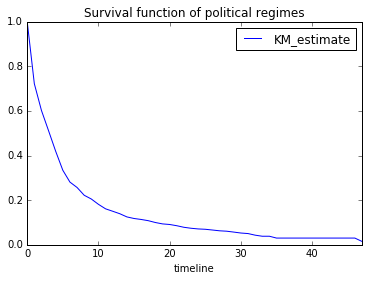

In [7]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

```How do we interpret this? The y-axis represents the probability a leader is still around after tt years, where tt years is on the x-axis. We see that very few leaders make it past 20 years in office. Of course, like all good stats, we need to report how uncertain we are about these point estimates, i.e. we need confidence intervals. They are computed in the call to fit, and are located under the confidence_interval_ property. (The mathematics can be found in these notes.)```

```Alternatively, we can call plot on the KaplanMeierFitter itself to plot both the KM estimate and its confidence intervals:```


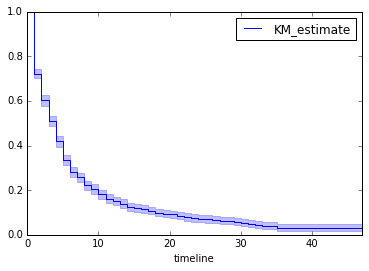

In [8]:
kmf.plot()

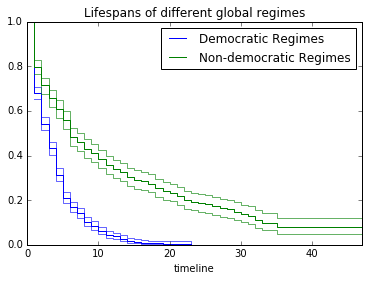

In [9]:
ax = plt.subplot(111)

dem = (data["democracy"] == "Democracy")
kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot(ax=ax, ci_force_lines=True)

plt.ylim(0, 1);
plt.title("Lifespans of different global regimes");

```We might be interested in estimating the probabilities in between some points. We can do that with the timeline argument. We specify the times we are interested in, and are returned a DataFrame with the probabilties of survival at those points:```




Median survival time of democratic: 3.0
Median survival time of non-democratic: 6.0


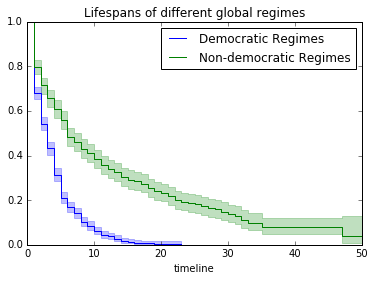

In [11]:
ax = plt.subplot(111)

t = np.linspace(0, 50, 51)
kmf.fit(T[dem], event_observed=E[dem], timeline=t, label="Democratic Regimes")
ax = kmf.plot(ax=ax)
print "Median survival time of democratic:", kmf.median_

kmf.fit(T[~dem], event_observed=E[~dem], timeline=t, label="Non-democratic Regimes")
ax = kmf.plot(ax=ax)
print "Median survival time of non-democratic:", kmf.median_

plt.ylim(0,1)
plt.title("Lifespans of different global regimes");

```Here the difference between survival functions is very obvious, and performing a statistical test seems pedantic. If the curves are more similar, or we possess less data, we may be interested in performing a statistical test. In this case, lifelines contains routines in lifelines.statistics to compare two survival curves. Below we demonstrate this routine. The function logrank_test is a common statistical test in survival analysis that compares two event series’ generators. If the value returned exceeds some prespecified value, then we rule that the series have different generators.```

In [12]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)

results.print_summary()

Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            260.470 |      Reject Null    |        True       


```Lets compare the different types of regimes present in the dataset:```

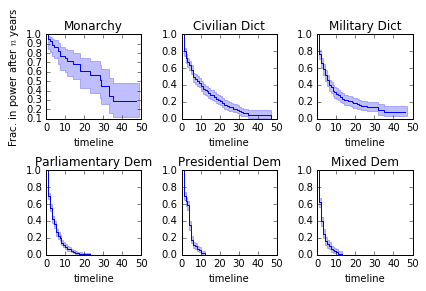

In [13]:
regime_types = data['regime'].unique()

for i,regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i+1)
    ix = data['regime'] == regime_type
    kmf.fit( T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)
    plt.title(regime_type)
    plt.xlim(0, 50)
    if i==0:
        plt.ylabel('Frac. in power after $n$ years')
plt.tight_layout()

Link to [Chapter 4](Survival%20Analysis%20ch%204.ipynb)